# Face Recognition

In [1]:
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people(min_faces_per_person = 70)

print(faces.target_names)
print(faces.images.shape)

# There are seven people to be recognized. Also, the shape of each image (62, 47), which means that each contains 
# [62×47] or nearly 3,000 pixels.

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']
(1288, 62, 47)


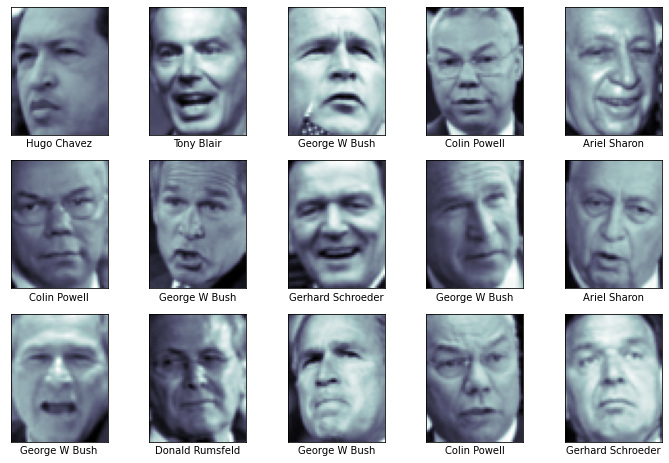

In [2]:
fig, ax = plt.subplots(3, 5, figsize = (12,8))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap = 'bone')
    axi.set(xticks = [], yticks = [], xlabel = faces.target_names[faces.target[i]])

In [3]:
# We will use a principal component analysis to extract 150 fundamental components to feed into our support vector 
# machine classifier

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

pca = PCA(n_components = 150, svd_solver = 'randomized', whiten = True)

svc = SVC(kernel = 'rbf', gamma = 0.005, C = 1000, class_weight = 'balanced')

model = Pipeline([('pca', pca), ('svc', svc)])

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(faces.data, faces.target, test_size = 0.3, random_state = 123)

In [5]:
model.fit(X_train, y_train)

Pipeline(steps=[('pca',
                 PCA(n_components=150, svd_solver='randomized', whiten=True)),
                ('svc', SVC(C=1000, class_weight='balanced', gamma=0.005))])

In [6]:
from sklearn.metrics import confusion_matrix

y_fit = model.predict(X_test)

confusion_matrix(y_test, y_fit)

array([[  9,   4,   1,   7,   1,   0,   0],
       [  1,  62,   0,   5,   0,   0,   0],
       [  0,   4,  32,  12,   1,   0,   1],
       [  0,   2,   1, 156,   0,   0,   0],
       [  0,   2,   0,   1,  24,   0,   1],
       [  0,   1,   0,   5,   0,  12,   1],
       [  0,   2,   0,   5,   0,   0,  34]])

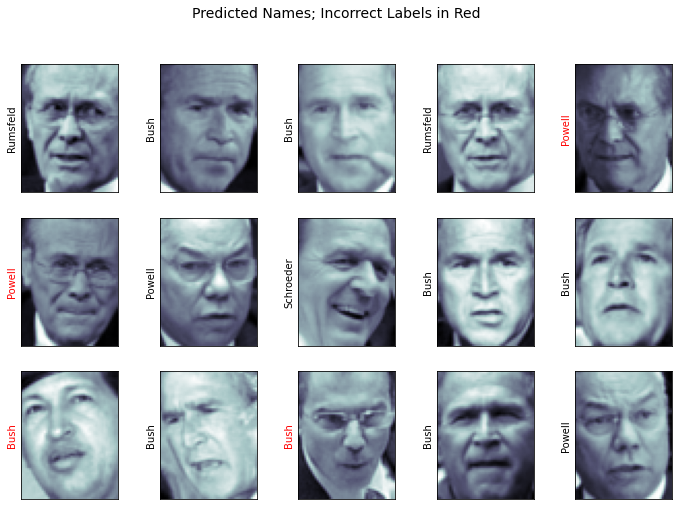

In [7]:
fig, ax = plt.subplots(3, 5, figsize = (12,8))

for i, axi in enumerate(ax.flat):
    axi.imshow(X_test[i].reshape(62,47), cmap = 'bone')
    axi.set(xticks = [], yticks = [])
    axi.set_ylabel(faces.target_names[y_fit[i]].split()[-1], color='black' if y_fit[i] == y_test[i] else 'red')
    
fig.suptitle('Predicted Names; Incorrect Labels in Red', size = 14);

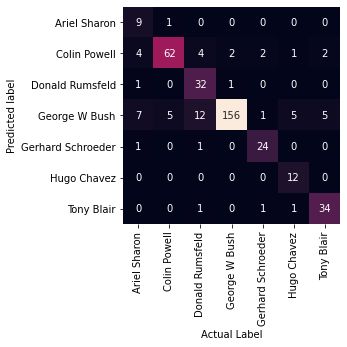

In [8]:
import seaborn as sns

mat = confusion_matrix(y_test, y_fit)
sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False, xticklabels = faces.target_names,
            yticklabels = faces.target_names)
plt.xlabel('Actual Label')
plt.ylabel('Predicted label');

## GridSearchCV 

In [9]:
from sklearn.model_selection import GridSearchCV

X_train_pca = pca.transform(X_train)

param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }

clf = GridSearchCV(SVC(kernel = 'rbf', class_weight = 'balanced'), param_grid, cv = 10)

clf = clf.fit(X_train_pca, y_train)

In [10]:
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.005)


## PCA - # of Features

In [11]:
pca = PCA(n_components = 10, svd_solver = 'randomized', whiten = True)
pca.fit(faces.data)

PCA(n_components=10, svd_solver='randomized', whiten=True)

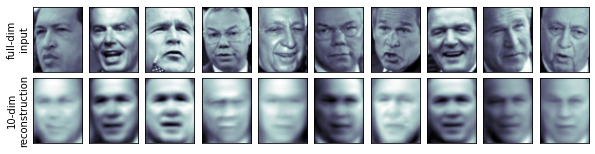

In [12]:
components = pca.transform(faces.data)
projected = pca.inverse_transform(components)

fig, ax = plt.subplots(2, 10, figsize = (10, 2.5), subplot_kw={'xticks':[], 'yticks':[]},
                      gridspec_kw = dict(hspace = 0.1, wspace = 0.1))

for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap = 'bone')
    ax[1, i].imshow(projected[i].reshape(62, 47), cmap = 'bone')
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('10-dim\nreconstruction');

# 10 features shows blurred images due to the low number of features.

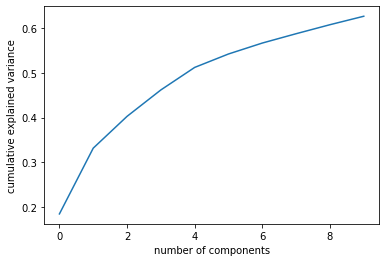

In [13]:
import numpy as np

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

# As we can see, the components can only explain a bit more than 60% of variance.

In [14]:
# We'll now try 250 components for betterment.

pca = PCA(n_components = 250, svd_solver = 'randomized', whiten = True)
pca.fit(faces.data)

PCA(n_components=250, svd_solver='randomized', whiten=True)

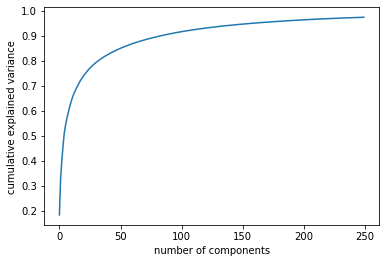

In [15]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

# The graph tells that 250 is more than enough to explain 90% or above of variance.

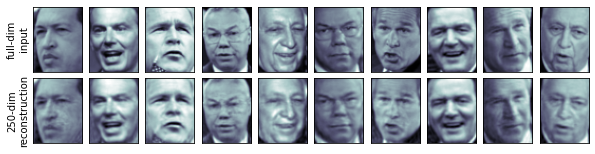

In [16]:
components = pca.transform(faces.data)
projected = pca.inverse_transform(components)

fig, ax = plt.subplots(2, 10, figsize = (10, 2.5), subplot_kw = {'xticks':[], 'yticks':[]},
                      gridspec_kw = dict(hspace = 0.1, wspace = 0.1))

for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap = 'bone')
    ax[1, i].imshow(projected[i].reshape(62, 47), cmap = 'bone')
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('250-dim\nreconstruction');

# Compared to the 10 components, 250 components can generate much clearer images.